# Conectando Python con Bases de Datos SQL Server

1. Instalar las librerías necesarias
2. Establecer la conexión a la base de datos
3. Ejecutar consultas SQL
4. Manejar resultados y cerrar la conexión
5. Manejo y visualización de datos con pandas

# 1. Instalar las librerías necesarias

In [2]:
%pip install pyodbc pandas

Note: you may need to restart the kernel to use updated packages.


# 2. Establecer la conexión a la base de datos

In [ ]:
import pyodbc
import pandas as pd

DB_HOST = 'testdb.ichika.02labs.me'
DB_PORT = '1433'
DATABASE = 'AcademicDB'
USERNAME = 'admin'
PASSWORD = 'MftkxKqOnYXsxEm2b4mo'
DRIVER = '{ODBC Driver 18 for SQL Server}'

server = f'{DB_HOST},{DB_PORT}'
conn_str = f'DRIVER={DRIVER};SERVER={server};DATABASE={DATABASE};UID={USERNAME};PWD={PASSWORD};Encrypt=yes;TrustServerCertificate=yes'

# Conectar y ejecutar una consulta de ejemplo
conn = None
try:
    conn = pyodbc.connect(conn_str, timeout=5)
    query = 'SELECT TOP 10 * FROM INFORMATION_SCHEMA.TABLES'
    df = pd.read_sql(query, conn)
    display(df.head())
except Exception as e:
    print('Error al conectar o ejecutar la consulta:', str(e))
finally:
    if conn:
        conn.close()

/tmp/ipykernel_3356/60703404.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,AcademicDB,Academic,Enrollments,BASE TABLE
1,AcademicDB,Academic,Departments,BASE TABLE
2,AcademicDB,Academic,Majors,BASE TABLE
3,AcademicDB,Academic,Instructors,BASE TABLE
4,AcademicDB,Academic,Students,BASE TABLE


# 3. Execute SQL queries

In [4]:
query = '''SELECT
    d.DepartmentName,
    COUNT(DISTINCT e.StudentID) AS StudentsEnrolled
FROM Academic.Enrollments e
JOIN Academic.Students s     ON s.StudentID = e.StudentID
JOIN Academic.Majors m       ON m.MajorID = s.MajorID
JOIN Academic.Departments d  ON d.DepartmentID = m.DepartmentID
GROUP BY d.DepartmentName
ORDER BY StudentsEnrolled DESC;
'''

try:
    conn = pyodbc.connect(conn_str, timeout=5)
    df = pd.read_sql(query, conn)
    display(df.head())
except Exception as e:
    print('Error al conectar o ejecutar la consulta:', str(e))
finally:
    if conn:
        conn.close()

/tmp/ipykernel_3356/835528921.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,DepartmentName,StudentsEnrolled
0,Computer Science,3
1,Mathematics,2
2,Physics,2
3,Literature,1


([0, 1, 2, 3],
 [Text(0, 0, 'Computer Science'),
  Text(1, 0, 'Mathematics'),
  Text(2, 0, 'Physics'),
  Text(3, 0, 'Literature')])

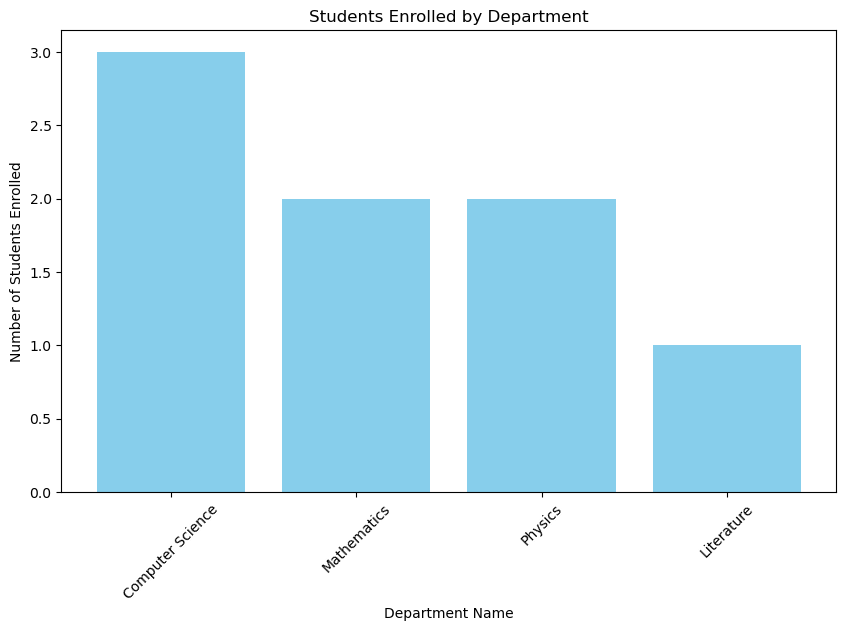

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(df['DepartmentName'], df['StudentsEnrolled'], color='skyblue')
plt.xlabel('Department Name')
plt.ylabel('Number of Students Enrolled')
plt.title('Students Enrolled by Department')
plt.xticks(rotation=45)

In [6]:
query = '''SELECT
    s.FirstName + ' ' + s.LastName AS Student,
    m.MajorName,
    d.DepartmentName
FROM Academic.Students s
JOIN Academic.Majors m ON s.MajorID = m.MajorID
JOIN Academic.Departments d ON m.DepartmentID = d.DepartmentID
ORDER BY d.DepartmentName, Student;
'''

try:
    conn = pyodbc.connect(conn_str, timeout=5)
    df_students = pd.read_sql(query, conn)
    display(df_students.head(10))
except Exception as e:
    print('Error al conectar o ejecutar la consulta:', str(e))
finally:
    if conn:
        conn.close()
    


/tmp/ipykernel_3356/3701224952.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_students = pd.read_sql(query, conn)


,Student,MajorName,DepartmentName
0,Alice Johnson,Computer Science,Computer Science
1,Erik Garcia,Software Engineering,Computer Science
2,Inés Ramírez,Computer Science,Computer Science
3,Diana Nguyen,Literature,Literature
4,Bob Smith,Mathematics,Mathematics
5,Fiona Lopez,Applied Mathematics,Mathematics
6,Charlie Brown,Physics,Physics
7,Hiro Sato,Physics,Physics


In [1]:
# Analizar inscripciones por estudiante y curso con clustering y t-SNE
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

enrollments_query = """SELECT\n    e.EnrollmentID,\n    s.StudentID,\n    CONCAT(s.FirstName, ' ', s.LastName) AS Student,\n    c.CourseID,\n    c.CourseName\nFROM Academic.Enrollments e\nJOIN Academic.Students s ON s.StudentID = e.StudentID\nJOIN Academic.Courses c ON c.CourseID = e.CourseID;\n"""
conn = None
try:
    conn = pyodbc.connect(conn_str, timeout=5)
    df_enrollments = pd.read_sql(enrollments_query, conn)
    display(df_enrollments.head())
finally:
    if conn:
        conn.close()

if df_enrollments.empty:
    print("No hay inscripciones registradas.")
else:
    enrollment_matrix = (
        df_enrollments
        .pivot_table(
            index="Student",
            columns="CourseName",
            values="EnrollmentID",
            aggfunc="count",
            fill_value=0
        )
        .sort_index()
    )

    display(enrollment_matrix.head())

    data_values = enrollment_matrix.values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_values)

    n_samples = data_scaled.shape[0]
    n_clusters = max(2, min(6, n_samples)) if n_samples > 1 else 1

    if n_samples == 1:
        cluster_labels = [0]
    else:
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(data_scaled)

    enrollment_matrix["cluster"] = cluster_labels

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        enrollment_matrix.drop(columns="cluster"),
        cmap="Blues",
        cbar=True,
        linewidths=0.5
    )
    plt.title("Matriz de inscripciones por estudiante y curso")
    plt.xlabel("Curso")
    plt.ylabel("Estudiante")
    plt.tight_layout()
    plt.show()

    perplexity = min(30, max(2, n_samples - 1))
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate="auto",
        init="random",
        random_state=42,
        n_iter=2000
    )
    tsne_coords = tsne.fit_transform(data_scaled)

    tsne_df = pd.DataFrame(
        tsne_coords,
        columns=["TSNE1", "TSNE2"],
        index=enrollment_matrix.index
    )
    tsne_df["cluster"] = cluster_labels

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=tsne_df,
        x="TSNE1",
        y="TSNE2",
        hue="cluster",
        palette="tab10",
        s=100
    )
    for student, (x, y) in tsne_df[["TSNE1", "TSNE2"]].iterrows():
        plt.text(x + 0.5, y + 0.5, student, fontsize=8)
    plt.title("Proyección t-SNE de estudiantes por patrón de inscripción")
    plt.tight_layout()
    plt.show()

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: numpy._core.multiarray failed to import